In [20]:
import numpy as np

In [21]:
path = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution\\GIFs\\6.0025720183715725"
# Load the data
locations = np.loadtxt(f"{path}\\locations.csv",
                  delimiter = ',')

concentrations = {}
for tf in range(1, 6):
    # concentrations[tf] = np.loadtxt(f"C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\concentrations_TF{tf}.csv",
    #               delimiter = ',')
    concentrations[tf] = np.loadtxt(f"{path}\\concentrations_TF{tf}.csv",
                  delimiter = ',')


#[cell.developed_module.substrate_coordinates[0], cell.developed_module.substrate_coordinates[1], 
#        slot4coordinates, potential_module_coord[0], potential_module_coord[1]]

# FRONT = 0
# RIGHT = 1
# BACK = 2
# LEFT = 3

In [22]:
coordinates, directions = [], {}
# Append core coordinates --> 3 x 3 central grid
for coord in [(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]:
    coordinates.append([coord[0], coord[1]])

xbounds = [0, 0]
ybounds = [0, 0]
for loc in locations:
    coordinates.append([loc[3], loc[4]])
    directions[tuple(coordinates[-1])] = {0: (int(np.sign(loc[3] - loc[0])), int(np.sign(loc[4] - loc[1])))}
    directions[tuple(coordinates[-1])][2] = (-int(np.sign(loc[3] - loc[0])), -int(np.sign(loc[4] - loc[1])))
    
    if (directions[tuple(coordinates[-1])][0] == (1, 0)):
        directions[tuple(coordinates[-1])][1] = (0, 1)
        directions[tuple(coordinates[-1])][3] = (0, -1)
    elif (directions[tuple(coordinates[-1])][0] == (0, 1)):
        directions[tuple(coordinates[-1])][1] = (-1, 0)
        directions[tuple(coordinates[-1])][3] = (1, 0)
    elif (directions[tuple(coordinates[-1])][0] == (-1, 0)):
        directions[tuple(coordinates[-1])][1] =  (0, -1)
        directions[tuple(coordinates[-1])][3] = (0, 1)
    elif (directions[tuple(coordinates[-1])][0] == (0, -1)):
        directions[tuple(coordinates[-1])][1] = (1, 0)
        directions[tuple(coordinates[-1])][3] = (-1, 0)
    else:
        print("Error")

    
    # x-coordinate
    try:
        assert directions[tuple(coordinates[-1])][0][0] + loc[0] == loc[3]
    except:
        assert directions[tuple(coordinates[-1])][0][0] * 2 + loc[0] == loc[3]
    # y-coordinate
    try:
        assert directions[tuple(coordinates[-1])][0][1] + loc[1] == loc[4]
    except:
        assert directions[tuple(coordinates[-1])][0][1] * 2 + loc[1] == loc[4]

    
    # Store bounds
    if loc[3] < xbounds[0]:
        xbounds[0] = loc[3]
    if loc[3] > xbounds[1]:
        xbounds[1] = loc[3]
    if loc[4] < ybounds[0]:
        ybounds[0] = loc[4]
    if loc[4] > ybounds[1]:
        ybounds[1] = loc[4]

# Append slot coordinates
xbounds = [min([xbounds[0], - 1]), max([xbounds[1], 1])]
ybounds = [min([ybounds[0], - 1]), max([ybounds[1], 1])]

In [23]:
grid = np.ones((max([int(xbounds[1] - xbounds[0]) + 1, 3]), max([int(ybounds[1] - ybounds[0] + 1), 3])))

# Set to 0 if not in body
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if [i + xbounds[0], j + ybounds[0]] not in coordinates:
            grid[i, j] = 0

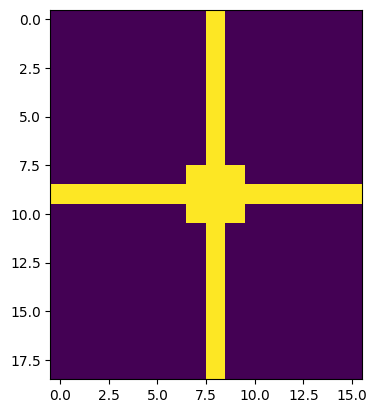

In [24]:
import matplotlib.pyplot as plt
plt.imshow(grid)

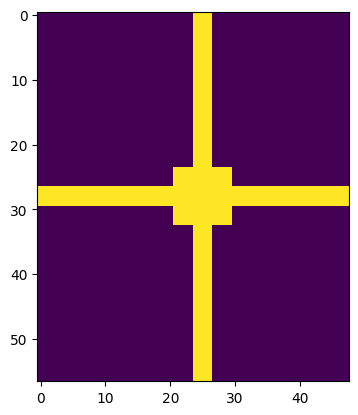

In [25]:
# Expand each grid cell to 3 x 3
expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        expanded_grid[i * 3: (i + 1) * 3, j * 3: (j + 1) * 3] = grid[i, j]

plt.imshow(expanded_grid)

In [26]:
# Write gif of the concentrations --> normalized per timestep
import gif

@gif.frame
def animate(gen):
    # ---- Plot
    # Initialize figure
    fig = plt.figure(figsize=(20, 20), facecolor = "white")
    ax = [fig.add_subplot(2, 3, i + 1) for i in range(0, 6)]
    fig.tight_layout()
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=8, hspace=None)
    # Initialize color map and norm
    cmap = plt.colormaps.get_cmap("coolwarm")
    minval = 0
    maxval = np.max([np.max(concentrations[tf][:, gen]) for tf in range(1, 6)])
    
    # Loop over the TFs
    for tf in range(1, 6):
        # Initialize grid
        expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))

        # Set the concentrations on an expanded grid for TF1
        middle_core = 0
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # # Save core index?
                # if (i + xbounds[0], j + ybounds[0]) == (0, 0):
                #     core_index = [i * 3, j * 3]
                
                if (grid[i, j] == 1) and ((i + xbounds[0], j + ybounds[0]) not in [(0, 0), (1, 1), (-1, -1), (-1, 1), (1, -1)]):
                    # Get index of the coordinates
                    idx_coordinates = coordinates.index([i + xbounds[0], j + ybounds[0]])
                    idx = idx_coordinates - 8 # Subtract 8 to get the correct index for the concentrations
                    # Check if core
                    if idx <= 0:
                        bool_core = True
                        idx += 3
                    else:
                        bool_core = False

                    # Tijdelijk --> core nog toevoegen
                    if not bool_core:
                        for c in range(4):
                            row = i * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][0]
                            col = j * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][1]
                            expanded_grid[row, col] = concentrations[tf][int(idx * 4 + c), gen]
                    else:
                        row = i * 3
                        col = j * 3
                        expanded_grid[row:int(row + 3), col:int(col + 3)] = concentrations[tf][int(idx * 4), gen]
                        middle_core += 0.25 * concentrations[tf][int(idx * 4), gen]

        #expanded_grid[core_index[0]:core_index[0] + 3, core_index[1]:core_index[1] + 3] = middle_core
        # ---- Plot
        ax[int(tf - 1)].imshow(expanded_grid, cmap = cmap, vmin = minval, vmax = maxval)
        if tf == 1:
            ax[int(tf - 1)].set_title(f"TF{tf}, t = {gen}", fontsize = 40, pad = 20, color = "black", fontweight = "bold")
        else:
            ax[int(tf - 1)].set_title(f"TF{tf}", fontsize = 40, pad = 20, color = "black", fontweight = "bold")
        ax[int(tf - 1)].axis("off")
        ax[int(tf - 1)].set_aspect("equal")
        ax[int(tf - 1)].set_xticklabels([])
        ax[int(tf - 1)].set_yticklabels([])
        # Remove tick indicators
        ax[int(tf - 1)].set_xticks([])
        ax[int(tf - 1)].set_yticks([])
    
    # ---- Set last figure blank
    ax[5].axis("off")
    ax[5].set_aspect("equal")
    ax[5].set_xticklabels([])
    ax[5].set_yticklabels([])
    # Remove tick indicators
    ax[5].set_xticks([])
    ax[5].set_yticks([])

    # ---- Return
    fig.tight_layout()

frames = []
for i in range(0, concentrations[1].shape[1]):
    # Print progress
    #print(f"Frame {i} of {concentrations[1].shape[1]}", end = "\r")
    # Append
    frames.append(animate(i))
    
# ----- Export gif
gif.save(frames, f"Tfs.gif", duration = 300)


# Analyze Genotype

In [27]:
import os
os.environ["ALGORITHM"] = "GRN_system"
os.environ["MODE"] = "evolution"
os.environ["DATABASE_FILE"] = ".sqlite"

# Import other modules
import pandas as pd
from experiment import Experiment
from generation import Generation
from individual import Individual
from population import Population
from sqlalchemy import select
from sqlalchemy.orm import Session

from revolve2.experimentation.database import OpenMethod, open_database_sqlite
from revolve2.experimentation.logging import setup_logging

# Import parameters
import config
os.environ['MAXPARTS'] = str(config.MAX_PARTS)

# Import the genotype
if os.environ["ALGORITHM"] == "CPPN":
    from genotype import Genotype
elif os.environ["ALGORITHM"] in ["GRN", "GRN_system", "GRN_system_adv"]:
    from genotype_grn import Genotype
else:
    raise ValueError("ALGORITHM must be either GRN or CPPN")

In [28]:
def select_data(dbengine, column: str) -> pd.DataFrame:
    """Goal:
        Select the data of the column
    -------------------------------------------------------------
    Input:
        dbengine: ?
        column: The column that needs to be selected
    --------------------------------------------------------------
    Output:
        df: pd.Dataframe"""
    df = pd.read_sql(
        select(Genotype, Experiment.id.label("experiment_id"), Generation.generation_index, 
               getattr(Individual, column), Individual.id.label("individual_id"),
               Individual.body_id)
        .join_from(Experiment, Generation, Experiment.id == Generation.experiment_id)
        .join_from(Generation, Population, Generation.population_id == Population.id)
        .join_from(Population, Individual, Population.id == Individual.population_id)
        .join_from(Individual, Genotype, Individual.genotype_id == Genotype.id),
        dbengine,
    )

    return df

In [29]:
column = "fitness"
folder_path = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution\\"

In [30]:
mappings = {0: "concentration threshold", 1: "concentration decay", 2: "intra diffusion rate",
 3: "inter diffusion rate", 4: "capacity core", 5: "capacity hinge", 6: "capacity brick",}

In [31]:
df = pd.DataFrame([])
n_exp = 0
for file in os.listdir(folder_path):
    print("File:", file)
    if file.endswith(".sqlite"):
        # Open database
        dbengine = open_database_sqlite(folder_path + "\\" + file, open_method=OpenMethod.OPEN_IF_EXISTS)

        # Get pandas data
        df_sub = select_data(dbengine, column)
        df_sub["experiment_id"] = ((df_sub["experiment_id"] - df_sub["experiment_id"].min()) + n_exp).astype(int).values
        # Print ids and max fitness
        ids = df_sub["experiment_id"].unique()
        for id in ids:
            print(f"Experiment {id}: {df_sub.loc[df_sub['experiment_id'] == id, column].max()}")
        
        # Convert genotype columns
        #df_sub["length genotype"] = df_sub["serialized_body"].apply(lambda x: x.count(",")) + 1
        #genotype = df_sub["serialized_body"].apply(lambda x: [float(ix) for ix in x.split(',')[0:7]])

        # for imap, keymap in mappings.items():
        #     df_sub[keymap] = genotype.apply(lambda x: x[imap])

        
        # Drop serialized_body, serialized_brain
        df_sub = df_sub.drop(columns = ["serialized_body", "serialized_brain"])

        # Update n_exp
        n_exp = df_sub["experiment_id"].max() + 1

        # Concat data
        df = pd.concat([df, df_sub], axis = 0)

# Save data
df.to_csv(f"genotype_and_fitness_{os.environ['ALGORITHM']}.csv", index = False)

# # Select even generations
# if os.environ["MODE"] == "evolution":
#     first_generation = df.loc[df["generation_index"] == 0, :]
#     df = df.loc[(df.loc[:, "generation_index"] % 2) == 0, :]
#     df = pd.concat([first_generation, df])
#     df["generation_index"] = (df.loc[:, "generation_index"] / 2).astype(int).values
# else:
#     raise ValueError("MODE must be evolution")
        

File: CSV
File: database_GRN_300_1.sqlite
Experiment 0: 9.805413927057321
File: database_GRN_300_10.sqlite
Experiment 1: 6.0025720183715725
Experiment 2: 3.817138667715245
File: database_GRN_300_11.sqlite
Experiment 3: 6.414818702949956
File: database_GRN_300_12.sqlite
Experiment 4: 9.07365448242234
File: database_GRN_300_13.sqlite
Experiment 5: 6.420431262871015
File: database_GRN_300_2.sqlite
Experiment 6: 10.587086858382674
Experiment 7: 6.197483584028902
File: database_GRN_300_3.sqlite
Experiment 8: 7.212634011607761
Experiment 9: 10.727024154887758
File: database_GRN_300_4.sqlite
Experiment 10: 3.7395864359043505
File: database_GRN_300_5.sqlite
Experiment 11: 4.958725895528281
Experiment 12: 5.549891689130819
File: database_GRN_300_6.sqlite
Experiment 13: 4.238522933815388
File: database_GRN_300_7.sqlite
Experiment 14: 5.842911116031192
Experiment 15: 10.093784613435556
File: database_GRN_300_8.sqlite
Experiment 16: 7.139723657574412
Experiment 17: 13.106315281728701
File: databas

In [32]:
if os.environ["ALGORITHM"] == "GRN_system":
    if os.environ["MODE"] == "evolution":
        path2morph = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution\\CSV\\Morphology.csv"
        df_morph = pd.read_csv(path2morph)
    else:
        pass
elif os.environ["ALGORITHM"] == "CPPN":
    if os.environ["MODE"] == "evolution":
        path2morph = "C:\\Users\\niels\\Downloads\\CPPN\\Evolution\\Morphology.csv"
        df_morph = pd.read_csv(path2morph)
elif os.environ["ALGORITHM"] == "GRN":
    if os.environ["MODE"] == "evolution":
        path2morph = "C:\\Users\\niels\\Downloads\\GRN_runs\\CSV\\Morphology.csv"
        df_morph = pd.read_csv(path2morph)
    else:
        pass

df = pd.read_csv(f"genotype_and_fitness_{os.environ['ALGORITHM']}.csv")

In [33]:
# Sort values
df = df.sort_values(by = ["experiment_id", "generation_index", "individual_id"])
df_morph = df_morph.sort_values(by = ["experiment_id", "generation_index", "individual_index"])

# Map4match
map4match = {}
for exp in df["experiment_id"].unique():
    if os.environ["ALGORITHM"] != "GRN":
        data_exp_id = df.loc[df["experiment_id"] == exp, "body_id"]
    else: # Because I had no body_id in the GRN runs, because I developed it later on
        loczeros = (df.loc[df["experiment_id"] == exp, "fitness"] == 7.950135414923488e-19)

    map4match[exp] = None
    for exp_morph in df_morph["experiment_id"].unique():
        data_exp_id_morph = df_morph.loc[df_morph["experiment_id"] == exp_morph, "id_string"]
        if os.environ["ALGORITHM"] != "GRN":
            if (data_exp_id_morph[0:10].values == data_exp_id[0:10].values).all():
                assert map4match[exp] is None
                map4match[exp] = exp_morph
            else: pass
        else:
            loczeros2 = data_exp_id_morph == "1|"
            if pd.Series(loczeros.values).equals(pd.Series(loczeros2.values)):
                assert map4match[exp] is None
                map4match[exp] = exp_morph
            else: pass        

In [34]:
print(map4match)
assert len(np.unique(map4match.values())[0]) == len(map4match.values())

{0: 1, 1: 19, 2: 20, 3: 21, 4: 23, 5: 25, 6: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 9, 12: 10, 13: 11, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18}


In [35]:
# Add morphological data
df.replace({"experiment_id": map4match}, inplace = True)
df.sort_values(by = ["experiment_id", "generation_index", "individual_id"], inplace = True)
df.reset_index(drop = True, inplace = True)
df_morph.sort_values(by = ["experiment_id", "generation_index", "individual_index"], inplace = True)
df_morph.reset_index(drop = True, inplace = True)

# Check duplicate columns
for col in df.columns:
    if col in df_morph.columns:
        assert (df[col] == df_morph[col]).all()
        df = df.drop(columns = col)
# # Concatenate the data
df = pd.concat([df, df_morph], axis = 1)

In [36]:
print(df.columns)

Index(['id', 'fitness', 'individual_id', 'body_id', 'bricks', 'hinges',
       'modules', 'size', 'proportion2d', 'proportionNiels',
       'single_neighbour_brick_ratio', 'single_neighbour_ratio',
       'double_neighbour_brick_and_active_hinge_ratio', 'maxrel_llimbs',
       'meanrel_llimbs', 'stdrel_llimbs', 'nlimbs', 'joints',
       'joint_brick_ratio', 'symmetry_incl1', 'symmetry_incl2',
       'symmetry_incl3', 'symmetry_incl4', 'symmetry_excl1', 'symmetry_excl2',
       'symmetry_excl3', 'symmetry_excl4', 'coverage', 'branching',
       'surface_area', 'id_string', 'experiment_id', 'generation_index',
       'individual_index'],
      dtype='object')


In [37]:
assert df["body_id"].equals(df["id_string"])
assert df["individual_id"].equals(df["individual_index"])
df.drop(columns = ["body_id", "individual_id"], inplace = True)
df.to_csv(f"morphology_and_fitness_evo_{os.environ['ALGORITHM']}.csv", index = False)

KeyError: "['length genotype', 'concentration threshold', 'concentration decay', 'intra diffusion rate', 'inter diffusion rate', 'capacity core', 'capacity hinge', 'capacity brick'] not in index"

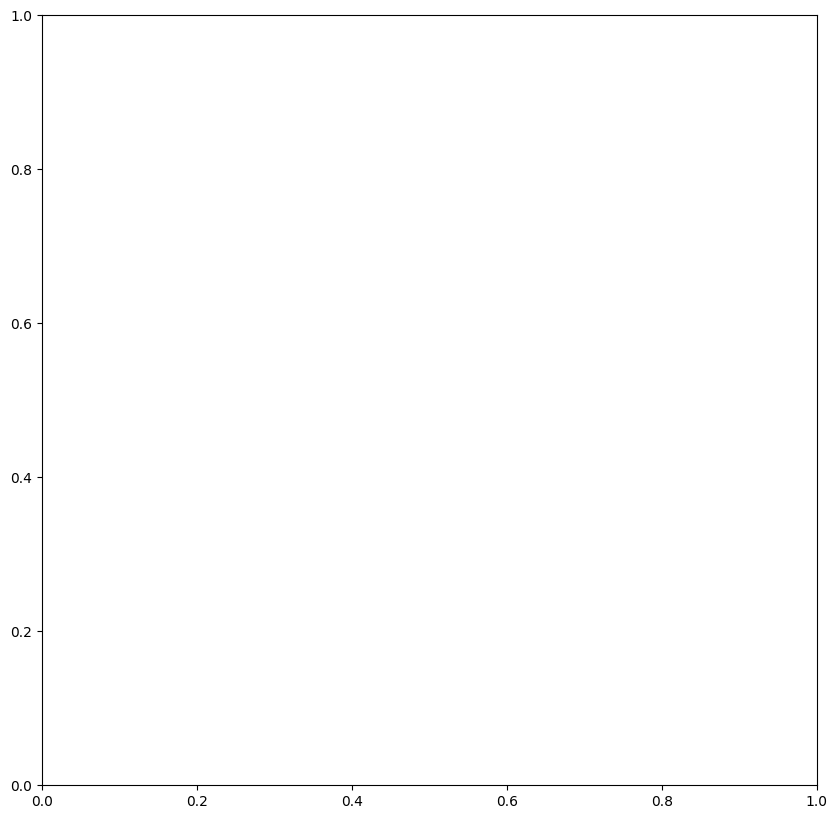

In [38]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Data
columns = ["fitness", "length genotype"] + list(mappings.values())
data = df.loc[df["generation_index"] == 600, columns]
# Normalize data
data = (data - data.mean()) / data.std()

# Plot
plt.boxplot(data, widths = 0.6, patch_artist = True, boxprops=dict(facecolor="red"))
ax.set_xlabel("Generation", fontsize = 15, fontweight = "bold")
ax.set_ylabel("Normalized values", fontsize = 15, fontweight = "bold")
ax.set_title("Boxplot of the fitness and genotype parameters", fontsize = 20, fontweight = "bold")
ax.set_xticklabels(columns, rotation = 45, ha = "right")
# Remove axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# Set axes thickness
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
# Remove tick indicators on axes
ax.tick_params(which = "both", width = 0)
ax.legend()
plt.show()

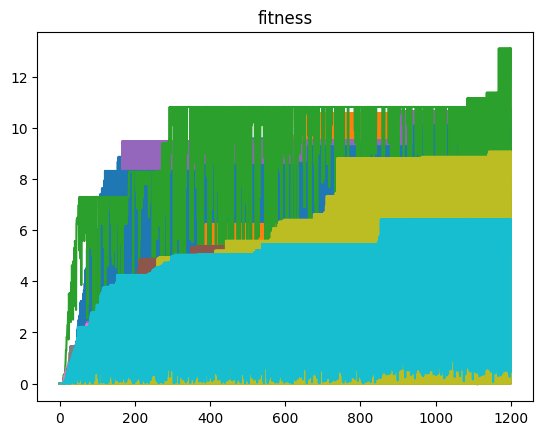

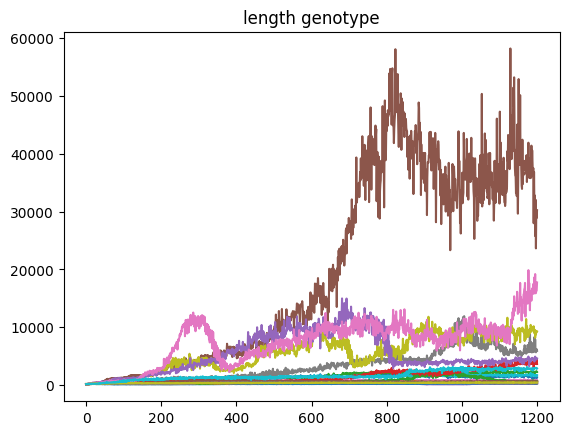

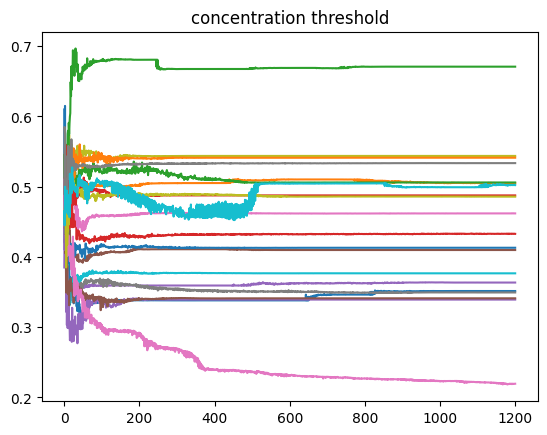

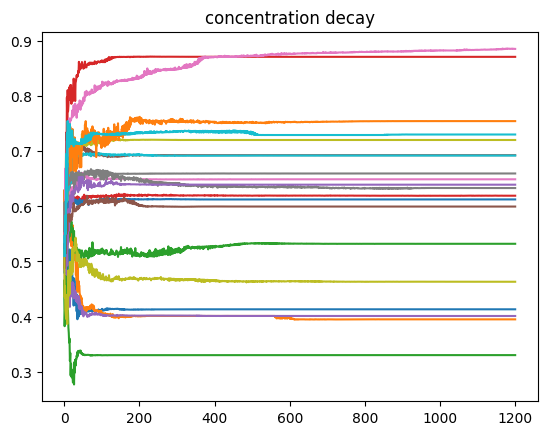

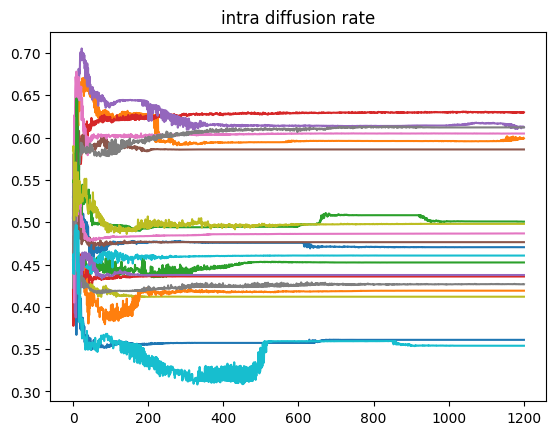

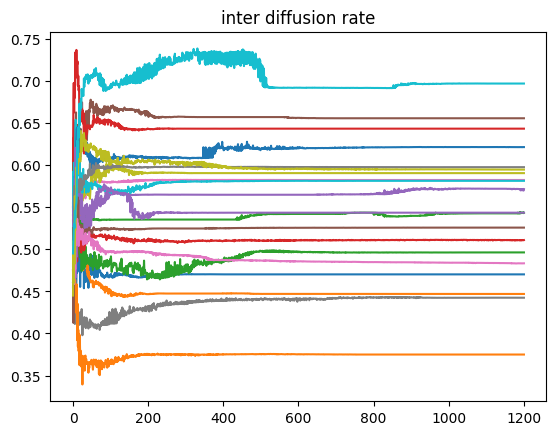

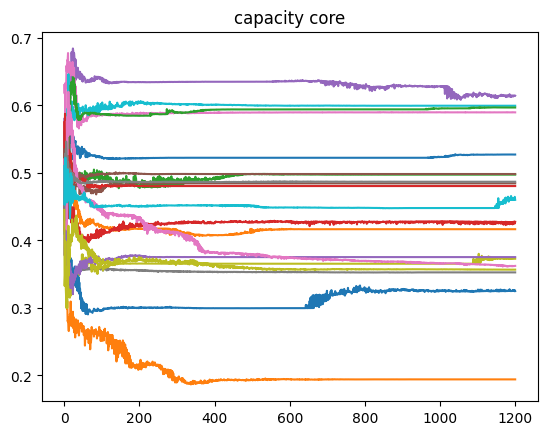

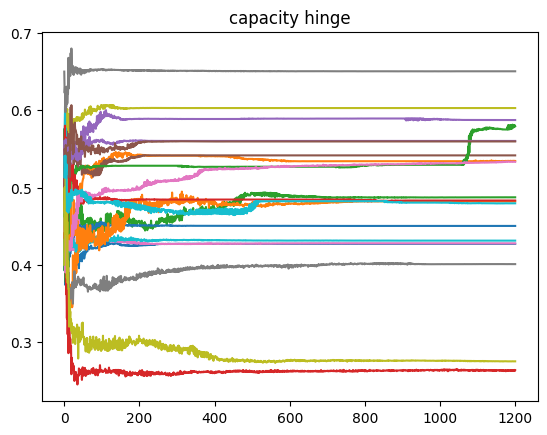

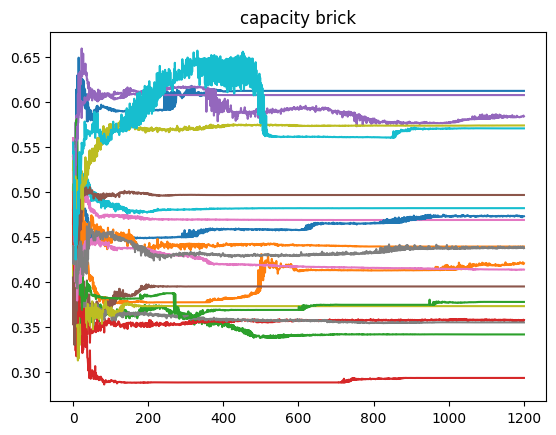

In [ ]:
data = df.loc[:, ["generation_index", "experiment_id"] + columns].groupby(["experiment_id", "generation_index"]).median()

for column in columns:
    plt.plot(data[column].unstack().T)
    plt.title(column)
    plt.show()

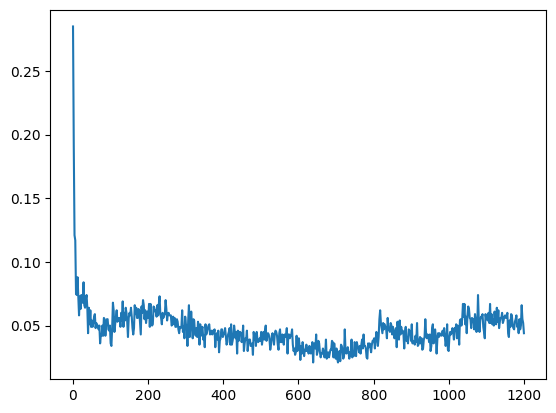

In [ ]:
# Get offspring
df_offspring = df.loc[df["generation_index"] % 2 != 0, :]

# Get percentage of ids that equals "1|" per generation
percentage = df_offspring.loc[df_offspring["id_string"] == "1|", :].groupby("generation_index").size() / df_offspring.groupby("generation_index").size()

plt.plot(percentage)


C:\Users\niels\AppData\Local\Temp\ipykernel_14320\2921204200.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation = 45, ha = "right")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


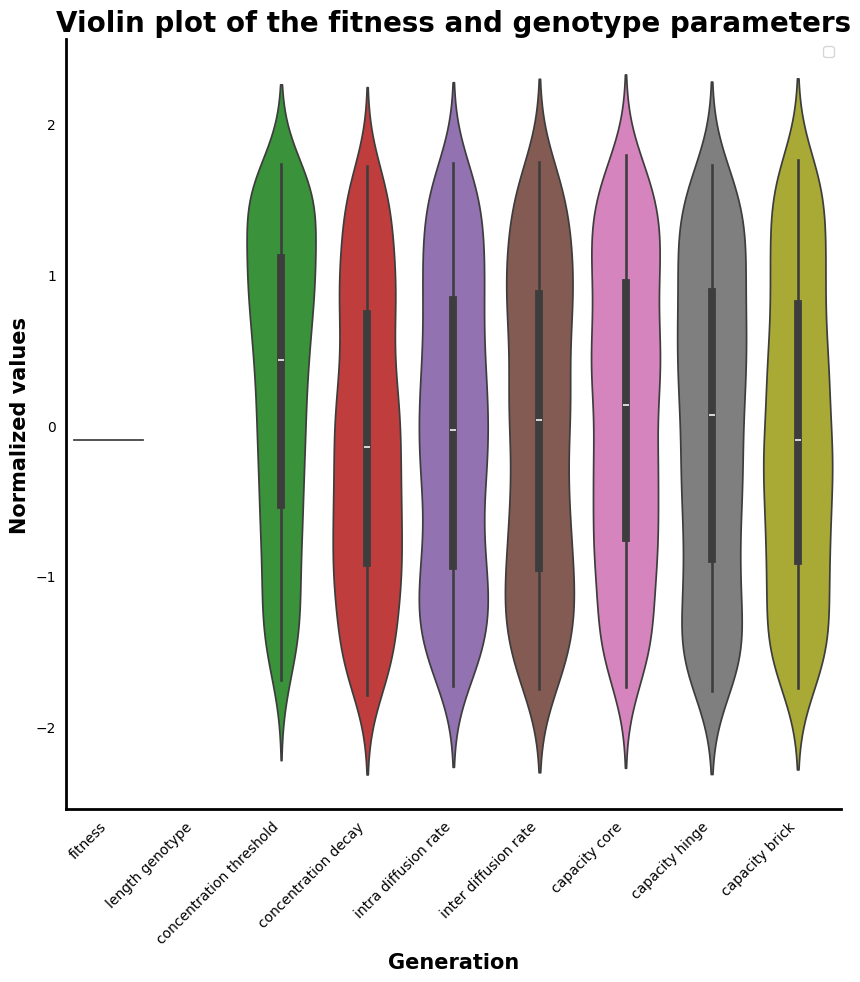

In [ ]:
import seaborn as sns
# Data
columns = ["fitness", "length genotype", "body_id"] + list(mappings.values())
data = df.loc[df["generation_index"] == 0, columns]
body_ids = data["body_id"].values
data = data.drop(columns = "body_id")
columns.remove("body_id")
# Normalize data
data = (data - data.mean()) / data.std()

# Select
data = data.loc[body_ids == "1|", columns]

# # Plot
# fig, ax = plt.subplots(1, 1, figsize = (10, 10))
# plt.boxplot(data, widths = 0.6, patch_artist = True, boxprops=dict(facecolor="red"))
# ax.set_xlabel("Generation", fontsize = 15, fontweight = "bold")
# ax.set_ylabel("Normalized values", fontsize = 15, fontweight = "bold")
# ax.set_title("Boxplot of the fitness and genotype parameters", fontsize = 20, fontweight = "bold")
# ax.set_xticklabels(columns, rotation = 45, ha = "right")
# # Remove axes
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# # Set axes thickness
# ax.spines["left"].set_linewidth(2)
# ax.spines["bottom"].set_linewidth(2)
# # Remove tick indicators on axes
# ax.tick_params(which = "both", width = 0)
# ax.legend()
# plt.show()
# Violin plot
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.violinplot(data = data, ax = ax)
ax.set_xlabel("Generation", fontsize = 15, fontweight = "bold")
ax.set_ylabel("Normalized values", fontsize = 15, fontweight = "bold")
ax.set_title("Violin plot of the fitness and genotype parameters", fontsize = 20, fontweight = "bold")
ax.set_xticklabels(columns, rotation = 45, ha = "right")
# Remove axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# Set axes thickness
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
# Remove tick indicators on axes
ax.tick_params(which = "both", width = 0)
ax.legend()
plt.show()

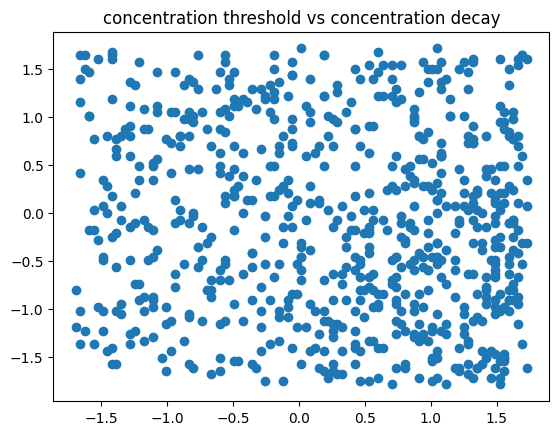

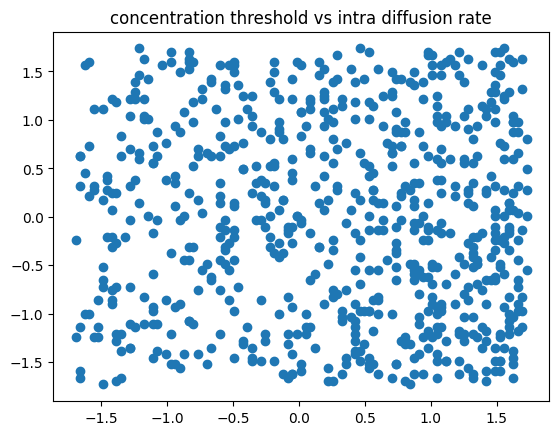

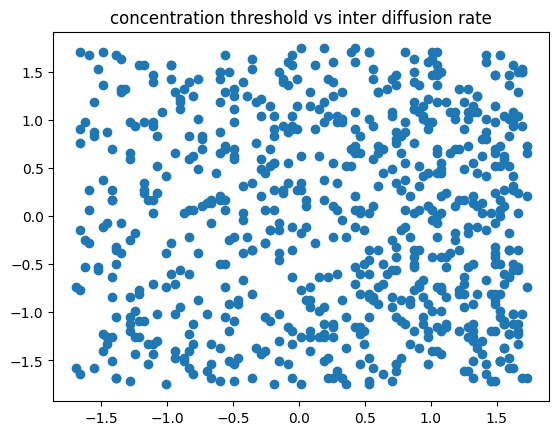

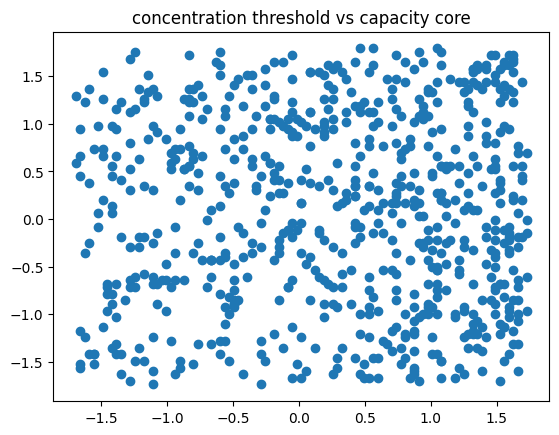

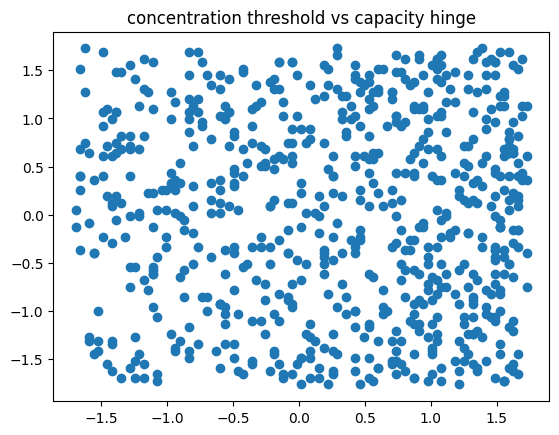

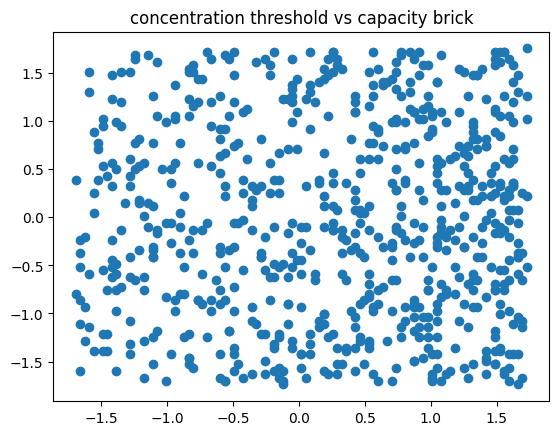

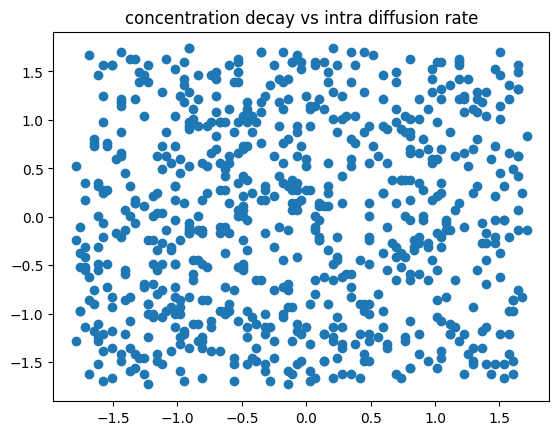

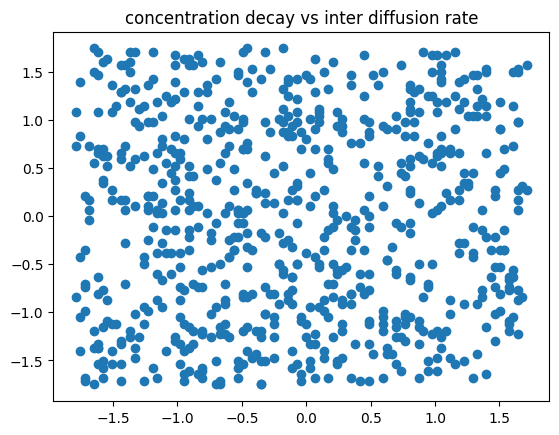

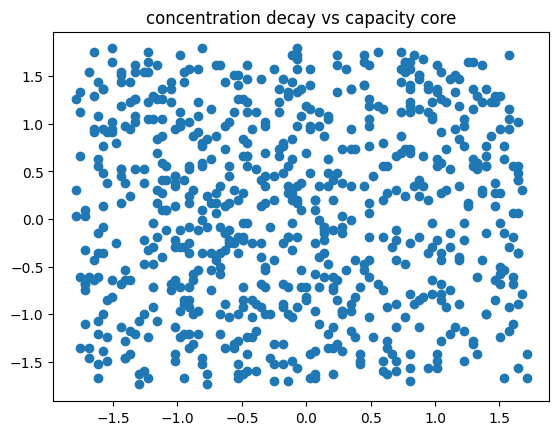

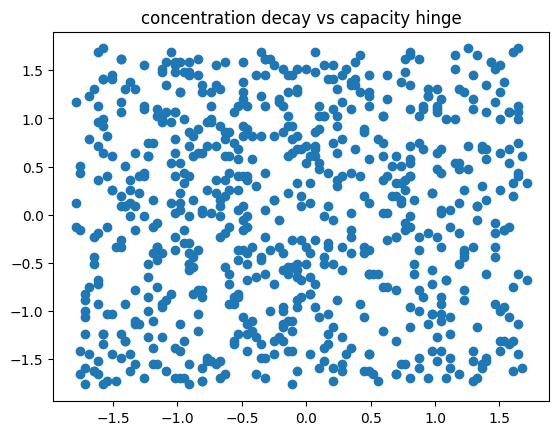

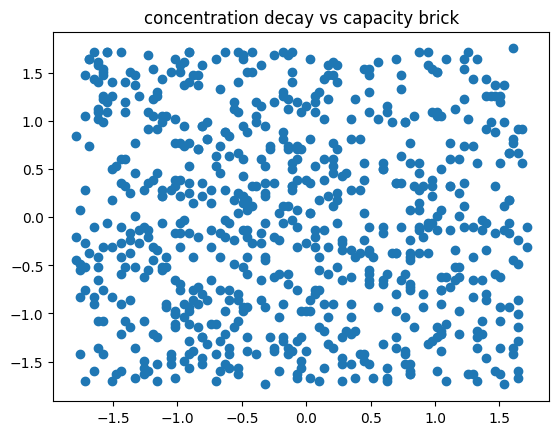

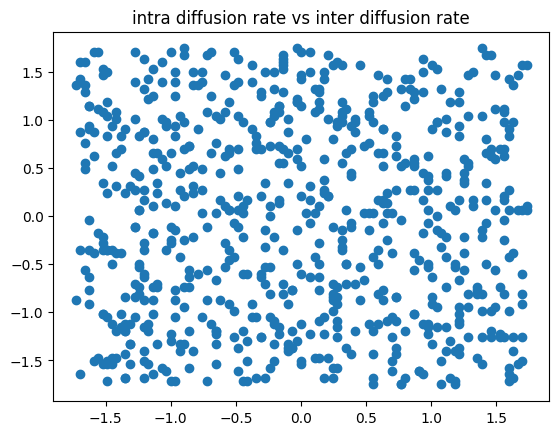

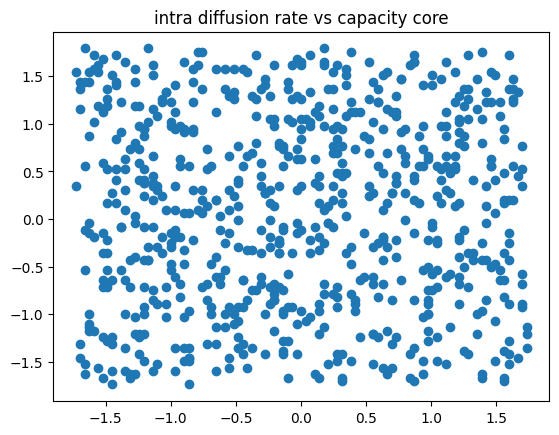

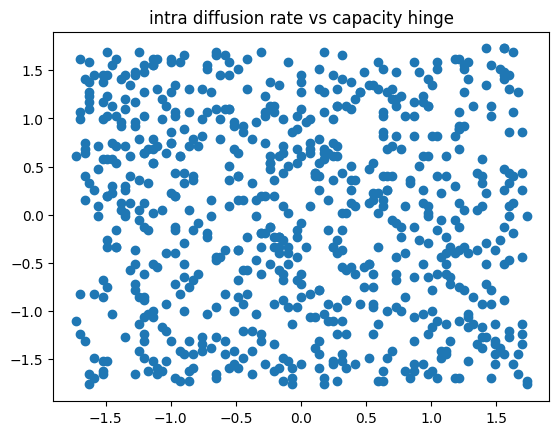

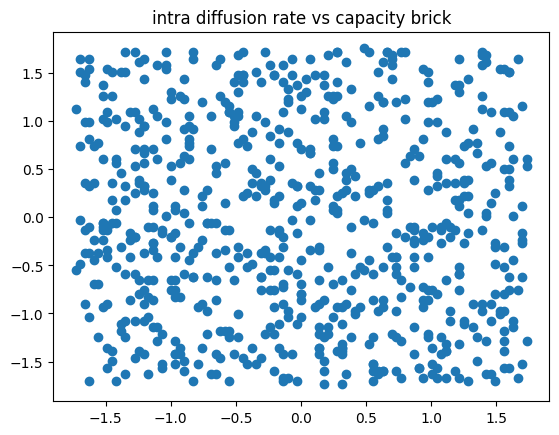

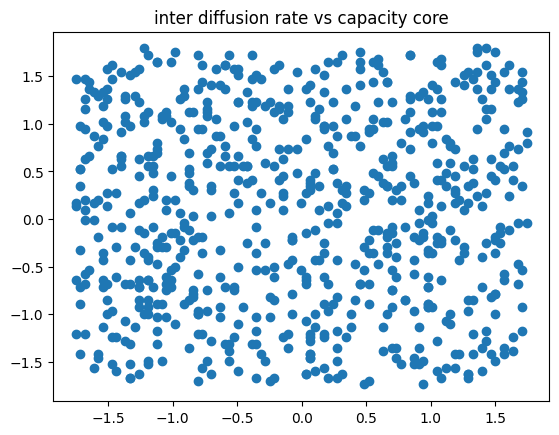

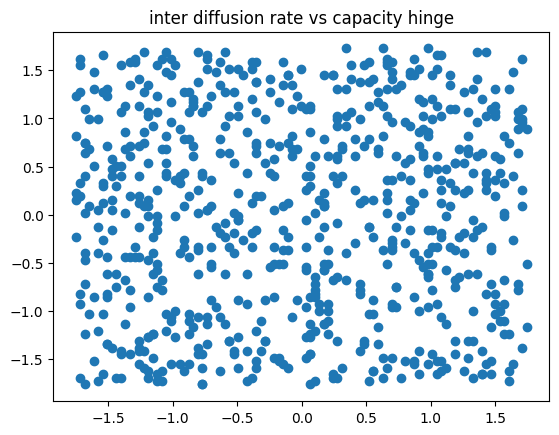

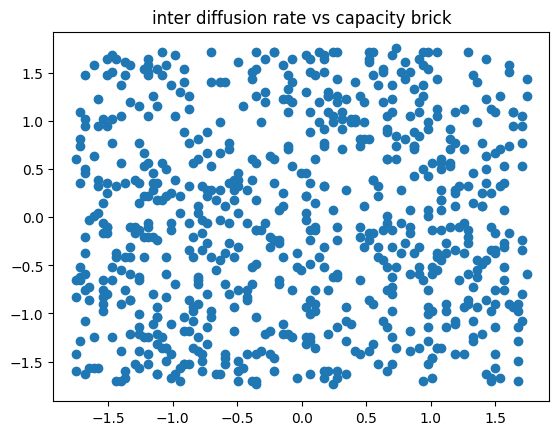

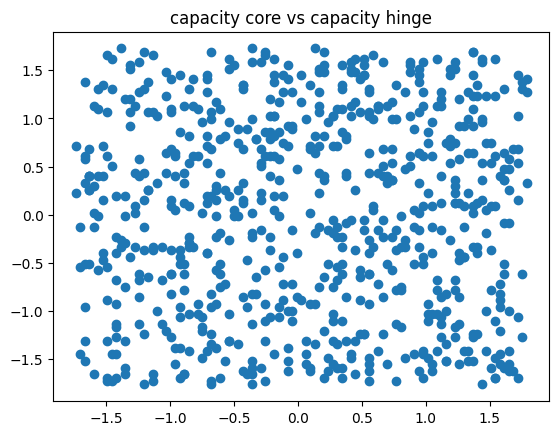

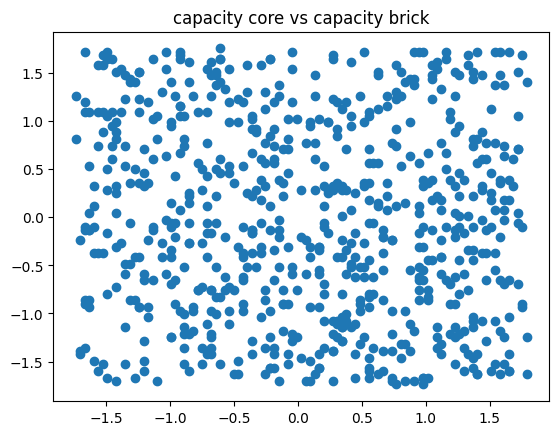

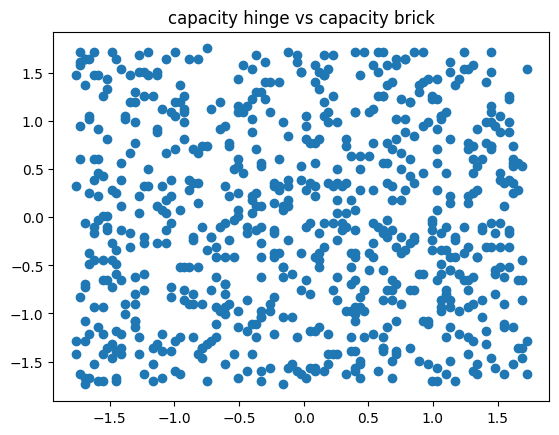

In [ ]:
# Data
columns = ["fitness", "length genotype", "body_id"] + list(mappings.values())
data = df.loc[df["generation_index"] == 0, columns]
body_ids = data["body_id"].values
data = data.drop(columns = "body_id")
columns.remove("body_id")
# Normalize data
data = (data - data.mean()) / data.std()

# Select
data = data.loc[body_ids == "1|", columns]

for icolumn, column in enumerate(columns):
    if column in ["fitness", "length genotype"]:
        continue
    for column2 in columns[icolumn + 1:]:
        plt.scatter(data[column], data[column2])
        plt.title(f"{column} vs {column2}")
        plt.show()